<span style="font-size: 14pt">MIPT, Advanced ML, Spring 2018</span>

Вспомогательный код с семинара

In [6]:
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
  """
  Compute numeric gradients for a function that operates on input
  and output blobs.
  
  We assume that f accepts several input blobs as arguments, followed by a blob
  into which outputs will be written. For example, f might be called like this:

  f(x, w, out)
  
  where x and w are input Blobs, and the result of f will be written to out.

  Inputs: 
  - f: function
  - inputs: tuple of input blobs
  - output: output blob
  - h: step size
  """
  numeric_diffs = []
  for input_blob in inputs:
    diff = np.zeros_like(input_blob.diffs)
    it = np.nditer(input_blob.vals, flags=['multi_index'],
                   op_flags=['readwrite'])
    while not it.finished:
      idx = it.multi_index
      orig = input_blob.vals[idx]

      input_blob.vals[idx] = orig + h
      f(*(inputs + (output,)))
      pos = np.copy(output.vals)
      input_blob.vals[idx] = orig - h
      f(*(inputs + (output,)))
      neg = np.copy(output.vals)
      input_blob.vals[idx] = orig
      
      diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

      it.iternext()
    numeric_diffs.append(diff)
  return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
  return eval_numerical_gradient_blobs(lambda *args: net.forward(),
              inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in xrange(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))



<h1 align="center">Organization Info</h1> 

* Дедлайн **20 апреля 2018 23:59** для всех групп.
* В качестве решения задания нужно прислать ноутбук с подробными комментариями.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2018_fall_<номер_группы>_<фамилия>``, к примеру -- ``ML2018_fall_495_ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb, к примеру`` -- ``ivanov_401_task6.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2018_fall Question <Содержание вопроса>``


--------
- **PS1:** Используются автоматические фильтры, и просто не найдем ваше дз, если вы неаккуратно его подпишите.
- **PS2:**  Просроченный дедлайн снижает максимальный вес задания по формуле, указнной на первом семинаре
- **PS3:** Допустимы исправление кода предложенного кода ниже, если вы считаете

# Home work 1: Basic Artificial Neural Networks

Credit https://github.com/yandexdataschool/YSDA_deeplearning17, https://github.com/DmitryUlyanov


Зачем это всё нужно?! Зачем понимать как работают нейросети внутри когда уже есть куча библиотек?
- Время от времени Ваши сети не учатся, веса становятся nan-ами, все расходится и разваливается -- это можно починить если понимать бекпроп
- Если Вы не понимаете как работают оптимизаторы, то не сможете правильно выставить гиперпарааметры :) и тоже ничего выучить не выйдет
- https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- hw6_Modules.ipynb

If you want to read more about backprop this links can be helpfull:
- http://udacity.com/course/deep-learning--ud730 
- http://cs231n.stanford.edu/2016/syllabus.html 
- http://www.deeplearningbook.org 

<h1 align="center">Check Questions</h1> 

**Вопрос 1**: Чем нейросети отличаются от линейных моделей, а чем похожи? 

Линейная модель реализуется однослойной нейросетью, т.е. является ее частным случаем. При этом, например, в задаче классификации линейная модель может выполнять лишь линейное (оптимальное) разделение выборки гиперплоскостью, а многослойная сеть может выполнять более сложное разделение (например, трехслойная сеть может найти любые многогранники в пространстве $\mathbb{R}^n$, в том числе невыпуклые и изолированные). Аналогично в задаче регрессии линейные модели восстанавливают лишь линейные зависимости (ваш кэп), а нейросети могут восстанавливать практически любые функции (это достигается за счет сложной внутренней структуры - можно добавлять и варьировать функции активации, менять количество слоев и их толщину и т.д.)

Зато оптимальное решение в линейной модели можно посчитать руками быстро и довольно точно, в то время как при переходе к (многослойным) сетям мы вынуждены прибегать к итеративным методам (по шагам улучшать текущее решение), которые не всегда сходятся, работают дольше и т.д.

**Вопрос 2**: В чем недостатки полносвзяных нейронных сетей, какая мотивация к использованию свёрточных?

Возникает проблема переобучения. Например, в задаче для обрабоки изображения размера 100x100 уже необходимо настроить минимум 10000 параметров (для простейшей однослойной сети). На малом наборе данных это легко приведет к переобучению. Также во входных данных могут содержаться шумы, и все эти шумы будут влиять и вносить ошибки в последующие слои. 

Сверточные сети очень хорошо подходят для обработки изображений, поскольку с помощью свертки они позволяют вытаскивать более высокоуровневые (и порою трудноинтерпретируемые) фичи изображения.

**Вопрос 3**: Какие слои используются в современных нейронных сетях? Опишите как работает каждый слой и свою интуицию зачем он нужен.
    
    - DenceLayer -- линейное преобразование Wx + b, можно интерпретировать как линейный классификатор. Очень много разных интерпретаций. 
    - DropOut Layer -- прореживание (например, по бернуллиевской маске). Для  решения проблемы переобучения
    - Convolutional Layer -- выполняет свертку (по данным генерирует новые, более сложные признаки) - слайдинг по данным и умножение окна на (многомерную) матрицу-фильтр 
    - их очень много
    
**Вопрос 4**: Может ли нейросеть решать задачу регрессии, какой компонент для этого нужно заменить в нейросети из лекции 1?

Конечно, может.

**Вопрос 5**: Почему обычные методы оптимизации плохо работают с нейросетями? А какие работают хорошо? Почему они работают хорошо?

Как правило, очень много параметров сети и очень высокая трудоемкость "наивных" вычислений.
Хорошо работает SGD (см. backprop, все дела). Еще есть метод Ньютона-Рафсона (похож на градиентный метод, но уже второго порядка). К сожалению, для точного вычисления требуется слишком много операций, поэтому применяют эвристики (диагонализация). Гораздо лучше себя ведет в окрестности локальных минимумов и не так сильно "перескакивает" через него.

**Вопрос 6**: Для чего нужен backprop, чем это лучше/хуже чем считать градиенты без него? Почему backprop эффективно считается на GPU?

Backprop позволяет эффективно считать градиент ошибки для каждого из параметров модели в многослойном перцептроне.

Для однократного честного вычисления значений градиентов функции в точке нужно порядка квадрата от количества операций, нужных для вычисления значения функции ошибки $L$. А это очень сложные вычисления. Этот факт еще долгое время останавливал развитие градиентных методов из-за слабых вычислительных возможностей компьютеров. Back propagation метод решает эту проблему, основная идея которого заключается в том, чтобы запомнить некоторые промежуточные значения, которые позволят быстро пересчитать значение градиента в обратном направлении по принципу chain rule.

Почему считается быстрее на GPU?

A group of neurons is used to process a part of data from the input data layer. The neurons are grouped together in such a way that minimizes the amount data that must be read. In this way, the same data can be used with several neurons at the same time. This minimizes the number of memory access cycles where the data can only be read serially. When the neurons have finished their job, another patch of input area is processed. If
necessary, another set of weights is used. Several groups of neurons can be executed in parallel by different
processing cores. In the hardware implementation as well as with the CUDA solution, each neuron from a group
is processed simultaneously with the others. An attempt was also made to parallelize the training of a multilayer ANN using back-propagation learning algorithm. (Короче, слой обрабатывается в несколько потоков сразу пачкой нейронов с быстрым доступом к памяти и быстрыми float-операциями) [Источник](http://www.ijesit.com/Volume%206/Issue%201/IJESIT201701_13.pdf).

**Вопрос 7**: Почему для нейросетей не используют кросс валидацию, что вместо неё? Можно ли ее использовать?

Кроссвалидацию использовать можно, но зачем? Есть дропаут. Он избавляет от переобучения, и по сути позволяет обучать на случайных подмножествах из входных данных. А обычная кроссвалидация может быть слишком трудоемкой - сеть может обучаться очень долго, и это просто лишняя трата вычислительных ресурсов.

**Вопрос 8**: Небольшой quiz который поможет разобраться со свертками https://www.youtube.com/watch?v=DDRa5ASNdq4 

<img src="img/conv.png" width="600">

<Ответ-Картинка :(>


-------------

Политика списывания. Вы можете обсудить решение с одногрупниками, так интереснее и веселее :) 
Не шарьте друг-другу код, в этом случаи вы ничему не научитесь -- "мыши плакали кололись но продолжали жрать кактус".

Теперь формально. Разница между списыванием и помощью товарища иногда едва различима. Мы искренне надеемся, что при любых сложностях вы можете обратиться к семинаристам и с их подсказками **самостоятельно** справиться с заданием. При зафиксированных случаях списывания (одинаковый код, одинаковые ошибки), баллы за задание будут обнулены всем участникам инцидента.

In [7]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Важно 

    - Не забывайте делать GradCheck, чтобы проверить численно что производные правильные, обычно с первого раза не выходит никогда, пример тут https://goo.gl/pzvzfe
    - Ваш код не должен содержать циклов, все вычисления должны бить векторные, внутри numpy 
    

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

### Your example

In [4]:
# Generate some data
# To turn on your example, run this

N = 200

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])

### My custom example

In [482]:
# to turn on my example, run this

from sklearn.datasets import make_circles
X, Y = make_circles(factor=0.7, random_state=0, noise=0.09, n_samples=N)
Y = np.vstack([Y, 1-Y]).T
X[X[:, 0] < 0, 0] = np.abs(X[X[:, 0] < 0, 0])

Изобразим данные:

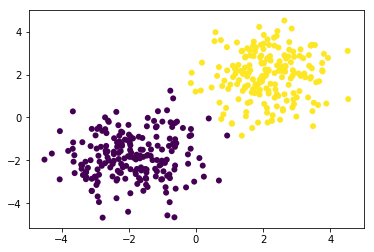

In [8]:
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [54]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run hw6_Modules.ipynb
print('done!')

done!


In [55]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

Define a **logistic regression** for debugging. 

### Linear classificator (for your example)

In [12]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = MSECriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state  = {}

# Looping params
n_epoch = 1000
batch_size = 1000

### 2-layer network (for my example)

In [495]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(2, 8))
net.add(ReLU())
net.add(Linear(8, 2))
net.add(SoftMax())
print(net)

# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state  = {}

# Looping params
n_epoch = 1000
batch_size = 100

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

### Train

Basic training loop. Examine it.

e0 e1 e2 e3 e4 e5 e6 e7 e8 e9 e10 e11 e12 e13 e14 e15 e16 e17 e18 e19 e20 e21 e22 e23 e24 e25 e26 e27 e28 e29 e30 e31 e32 e33 e34 e35 e36 e37 e38 e39 e40 e41 e42 e43 e44 e45 e46 e47 e48 e49 e50 e51 e52 e53 e54 e55 e56 e57 e58 e59 e60 e61 e62 e63 e64 e65 e66 e67 e68 e69 e70 e71 e72 e73 e74 e75 e76 e77 e78 e79 e80 e81 e82 e83 e84 e85 e86 e87 e88 e89 e90 e91 e92 e93 e94 e95 e96 e97 e98 e99 e100 e101 e102 e103 e104 e105 e106 e107 e108 e109 e110 e111 e112 e113 e114 e115 e116 e117 e118 e119 e120 e121 e122 e123 e124 e125 e126 e127 e128 e129 e130 e131 e132 e133 e134 e135 e136 e137 e138 e139 e140 e141 e142 e143 e144 e145 e146 e147 e148 e149 e150 e151 e152 e153 e154 e155 e156 e157 e158 e159 e160 e161 e162 e163 e164 e165 e166 e167 e168 e169 e170 e171 e172 e173 e174 e175 e176 e177 e178 e179 e180 e181 e182 e183 e184 e185 e186 e187 e188 e189 e190 e191 e192 e193 e194 e195 e196 e197 e198 e199 e200 e201 e202 e203 e204 e205 e206 e207 e208 e209 e210 e211 e212 e213 e214 e215 e216 e217 e218 e219 e220 e221 

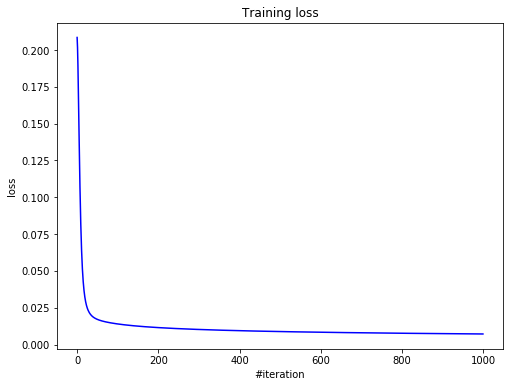

Current loss: 0.007198


In [13]:
loss_history = []

for i in range(n_epoch):
    print('e{}'.format(i), end=' ')
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
#         print("params:", net.getParameters())
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
#     display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

print('Current loss: %f' % loss)    

In [15]:
grid = []
for i in np.linspace(-4, 4, 100):
    for j in np.linspace(-4, 4, 100):
        grid.append([i, j])
grid = np.array(grid)

In [16]:
net.evaluate()
ans = net.forward(grid)[:, 0] > 0.5
ans

array([False, False, False, ...,  True,  True,  True], dtype=bool)

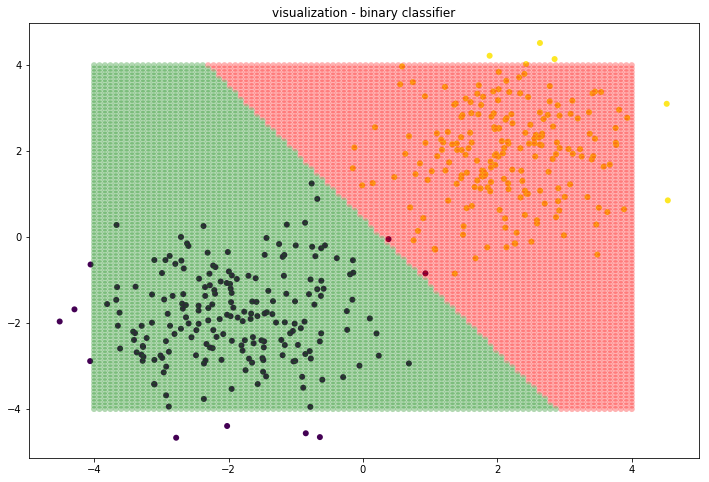

In [19]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
plt.scatter(grid[np.argwhere(ans), 0], grid[np.argwhere(ans), 1], 
            color='red',   alpha=0.3, edgecolors='none')
plt.scatter(grid[np.argwhere(np.logical_not(ans)), 0], grid[np.argwhere(np.logical_not(ans)), 1],
            color='green', alpha=0.3, edgecolors='none')
plt.title('visualization - binary classifier')
plt.show()

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [39]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [40]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(y.reshape(-1, 1)).toarray()

In [41]:
X.shape, y.shape

((70000, 784), (70000, 10))

In [42]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

In [44]:
X_train[:5], y_train[:5]

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

- **Compare** `ReLU`, `LeakyReLU` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

In [56]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 120))
net.add(ReLU())
net.add(Linear(120, 10))
net.add(SoftMax())
print(net)

Linear 120 -> 784
ReLU
Linear 10 -> 120
SoftMax



In [57]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.001, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 200

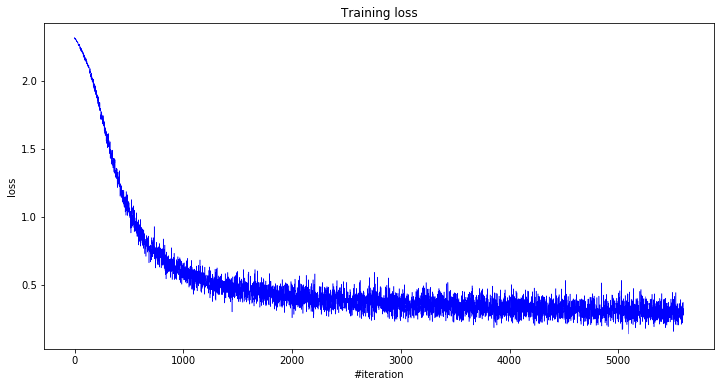

Current loss: 0.275091


In [58]:
loss_history = []

for i in range(n_epoch):
    print('e{}'.format(i), end=' ')
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b', lw=0.5)
    plt.show()

print('Current loss: %f' % loss)    

In [59]:
from sklearn.metrics import accuracy_score

net.evaluate()
ans = net.forward(X_test)
ans = np.argmax(ans, axis=1)

ans[:10], y_test[:10]

(array([3, 8, 2, 7, 3, 3, 8, 7, 0, 0]),
 array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

In [60]:
print('accuracy:', accuracy_score(ans, np.argmax(y_test, axis=1)))

accuracy: 0.917


**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [64]:
# Your code goes here. ################################################

# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 30
batch_size = 200

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 100))
net.add(LeakyReLU())
# net.add(Dropout(p=0.9))
# net.add(Linear(80, 40))
# net.add(LeakyReLU())
net.add(Linear(100, 10))
net.add(SoftMax())
print(net)

Linear 100 -> 784
LeakyReLU
Linear 10 -> 100
SoftMax



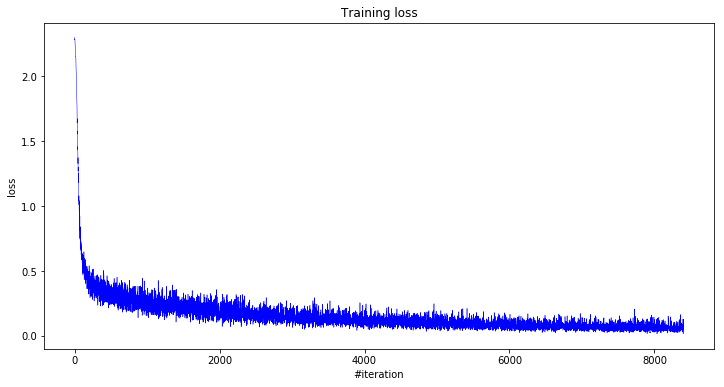

In [65]:
loss_history = []

for i in range(n_epoch):
    print('e{}/{}'.format(i, n_epoch), end=' ')
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b', lw=0.5)
    plt.show()

In [66]:
from sklearn.metrics import accuracy_score

net.evaluate()
ans = net.forward(X_test)
ans = np.argmax(ans, axis=1)

ans[:10], y_test[:10]

(array([3, 8, 7, 7, 3, 8, 8, 7, 0, 0]),
 array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

Print here your accuracy. It should be around 90%.

In [67]:
print('accuracy:', accuracy_score(ans, np.argmax(y_test, axis=1)))

accuracy: 0.970857142857


# Bonus Part: Autoencoder 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="img/autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [ ]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [ ]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 2))
cnet.add(SoftMax())

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################